In [1]:
import colorcet

In [2]:
A = 406.4
B = 410.7

alpha = 0.34
beta = 0.28

In [3]:
# loss as a function of params and data
# cf. eqn 10, https://arxiv.org/pdf/2203.15556.pdf

def l(n, d, A_=A, B_=B, alpha_=alpha, beta_=beta):
    # n, d in billions
    n = n * 1e9
    d = d * 1e9
    model_size_contribution = A_/(n ** alpha_)
    dataset_size_contribution = B_/(d ** beta_)
    # return 1.69 + model_size_contribution + dataset_size_contribution, (model_size_contribution, dataset_size_contribution)
    return 1.69 + model_size_contribution + dataset_size_contribution

# compute (flops) as a function of params and data
# cf. table A4, https://arxiv.org/pdf/2203.15556.pdf

def flops(n, d):
    # n, d in billions
    n = n * 1e9
    d = d * 1e9
    return 6 * n * d

In [4]:
# table 1, https://arxiv.org/pdf/2203.15556.pdf

# (n, d)
# jurassic omitted b/c too close to gpt3
model_hparams = dict(
    lamda=(137, 168),
    gpt3=(175, 300),
#     jurassic=(178, 300),
    gopher=(280, 300),
    mt_nlg=(530, 270),
    chinchilla=(70, 1400),
    palm=(540, 780),
    # llama70b=(70, 20000),
    llama70_optimal=(70, 1400)
)

In [5]:
print('Predicted losses by model')
for name, (n, d) in model_hparams.items():
    print((name, l(n, d)))

Predicted losses by model
('lamda', 2.0518647617856733)
('gpt3', 2.0022879365177095)
('gopher', 1.9932584616598494)
('mt_nlg', 1.9906149887818265)
('chinchilla', 1.9366454705587173)
('palm', 1.923874449165463)
('llama70_optimal', 1.9366454705587173)


In [6]:
print('Approx FLOPS by model')
for name, (n, d) in model_hparams.items():
    print((name, flops(n, d)))

Approx FLOPS by model
('lamda', 1.38096e+23)
('gpt3', 3.15e+23)
('gopher', 5.04e+23)
('mt_nlg', 8.586e+23)
('chinchilla', 5.88e+23)
('palm', 2.5272e+24)
('llama70_optimal', 5.88e+23)


In [7]:
import pandas as pd

df = pd.DataFrame(model_hparams, index=['n', 'd']).T

df['scaling_loss'] = [l(n, d) for n, d in zip(df.n, df.d)]
df['flops'] = [flops(n, d) for n, d in zip(df.n, df.d)]

In [8]:
# NMIN, NMAX, DMIN, DMAX = 30, 1600, 100, 1600
NMIN, NMAX, DMIN, DMAX = 30, 1600, 100, 22000


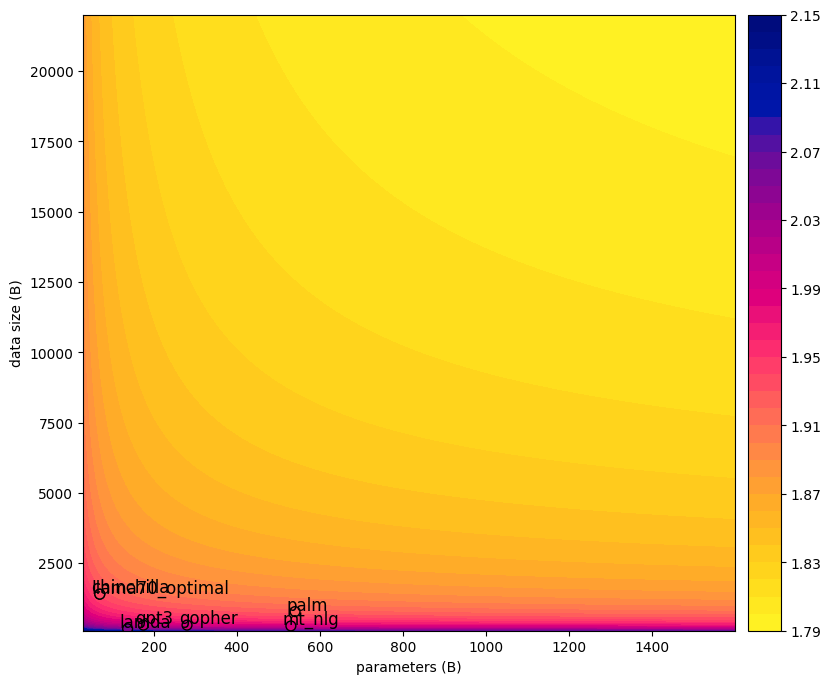

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

ns, ds = np.meshgrid(np.arange(NMIN, NMAX, 1), np.arange(DMIN, DMAX, 1))

lgrid =  l(ns, ds)

fig = plt.figure(figsize=(9, 8))

shared_kwargs = dict(cmap='cet_bmy_r', vmin=lgrid.min(), vmax=lgrid.max())

im = plt.contourf(ns, ds, lgrid, levels=40, **shared_kwargs)

ax = plt.gca()
plt.xlabel('parameters (B)')
plt.ylabel('data size (B)')

x_off = NMIN
y_off = DMIN

pcolor = 'k'

ax.scatter(df.n, df.d, c=df.scaling_loss, lw=1, edgecolors=pcolor, s=50, **shared_kwargs)

for name in df.index:
    plt.text(
        df.loc[name, 'n'] - 20, df.loc[name, 'd'] + 60, name,
        fontdict=dict(fontsize=12, color=pcolor)
    )

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax)

### same thing without the contours, just points

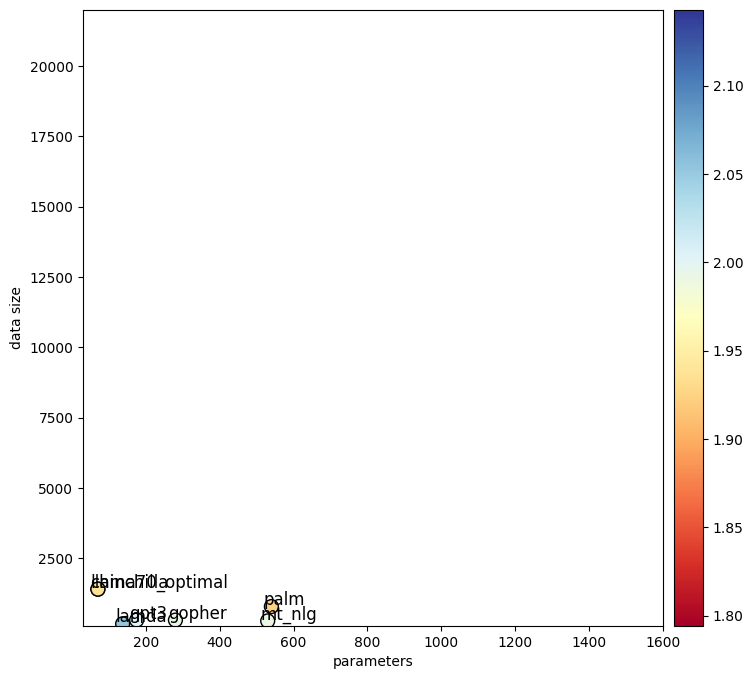

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(8, 8))
im = plt.scatter(df.n, df.d, c=df.scaling_loss, lw=1, edgecolors='k', s=100, cmap='RdYlBu', vmin=lgrid.min(), vmax=lgrid.max());


for name in df.index:
    plt.text(df.loc[name, 'n'] - 20, df.loc[name, 'd'] + 60, name, fontdict=dict(fontsize=12))

plt.axis([NMIN, NMAX, DMIN, DMAX]);
plt.xlabel('parameters')
plt.ylabel('data size')

ax = plt.gca()
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax)

### loss vs compute

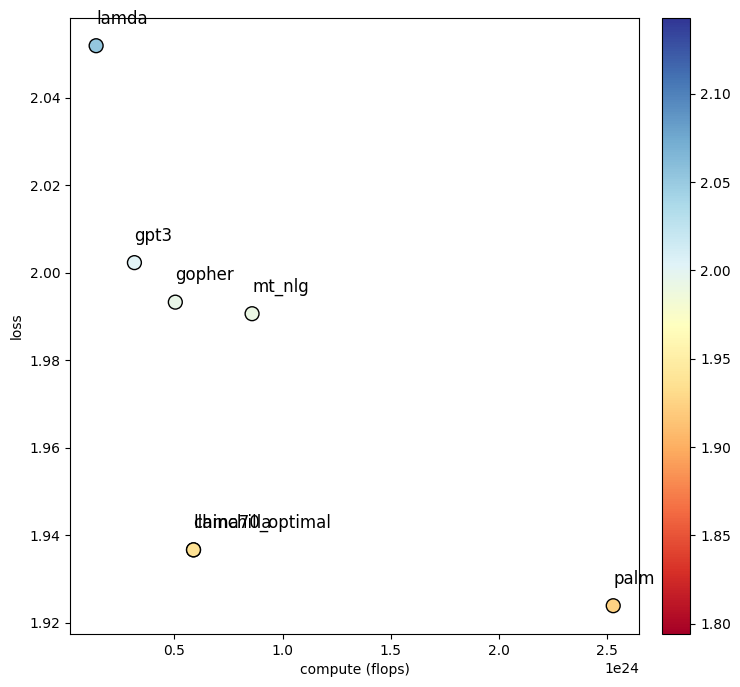

In [11]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(8, 8))

im = plt.scatter(df.flops, df.scaling_loss, lw=1, c=df.scaling_loss, edgecolors='k', s=100, cmap='RdYlBu', vmin=lgrid.min(), vmax=lgrid.max());

for name in df.index:
    plt.text(df.loc[name, 'flops'] - 60, df.loc[name, 'scaling_loss'] + 0.005, name, fontdict=dict(fontsize=12))

plt.xlabel('compute (flops)')
plt.ylabel('loss')

ax = plt.gca()
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="4%")
cb1 = fig.colorbar(im, cax=cax)

### imaginary models

In [12]:
## optimal scaling

G = ((alpha * A) / (beta * B)) ** (1/(alpha + beta))

a = beta/(alpha+beta)
b = alpha/(alpha+beta)

def n_opt(c, G_=G, a_=a, b_=b):
    return G_*((c/6)**a_)/1e9

def d_opt(c, G_=G, a_=a, b_=b):
    return (1/G_)*((c/6)**b_)/1e9

In [13]:
from copy import deepcopy

model_hparams_plus = deepcopy(model_hparams)

# model_hparams_plus['chinplus_N'] = (df.loc['palm', 'n'] * (780 / 1400), 1400)
# model_hparams_plus['chinplus_D'] = (70, df.loc['palm', 'd'] * (540 / 70))
model_hparams_plus['palm_opt'] = (n_opt(df.loc['palm', 'flops']), d_opt(df.loc['palm', 'flops']))

In [14]:
import pandas as pd

df2 = pd.DataFrame(model_hparams_plus, index=['n', 'd']).T

df2['scaling_loss'] = [l(n, d) for n, d in zip(df2.n, df2.d)]
df2['flops'] = [flops(n, d) for n, d in zip(df2.n, df2.d)]

df2

,n,d,scaling_loss,flops
lamda,137.000000,168.000000,2.051865,1.380960e+23
gpt3,175.000000,300.000000,2.002288,3.150000e+23
gopher,280.000000,300.000000,1.993258,5.040000e+23
mt_nlg,530.000000,270.000000,1.990615,8.586000e+23
chinchilla,70.000000,1400.000000,1.936645,5.880000e+23
palm,540.000000,780.000000,1.923874,2.527200e+24
llama70_optimal,70.000000,1400.000000,1.936645,5.880000e+23
palm_opt,62.770071,6710.204312,1.881845,2.527200e+24


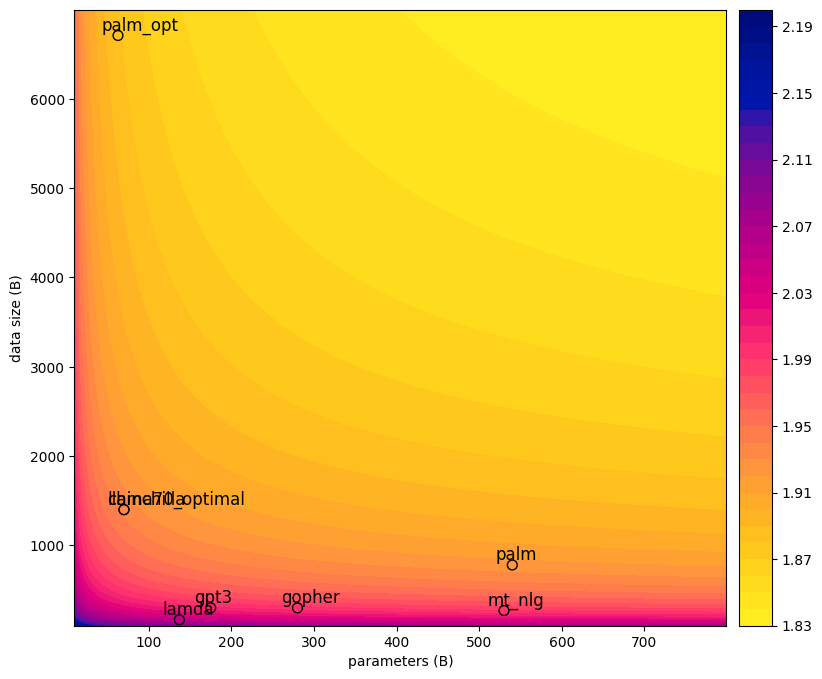

In [15]:
import numpy as np

NMIN, NMAX, DMIN, DMAX = 10, 800, 100, 7000

ns, ds = np.meshgrid(np.arange(NMIN, NMAX, 1), np.arange(DMIN, DMAX, 1))

lgrid =  l(ns, ds)
fig = plt.figure(figsize=(9, 8))

shared_kwargs = dict(cmap='cet_bmy_r', vmin=lgrid.min(), vmax=lgrid.max())

im = plt.contourf(ns, ds, lgrid, levels=40, **shared_kwargs)

ax = plt.gca()
plt.xlabel('parameters (B)')
plt.ylabel('data size (B)')

x_off = NMIN
y_off = DMIN

ax.scatter(df2.n, df2.d, c=df2.scaling_loss, lw=1, edgecolors='k', s=50, **shared_kwargs)

for name in df2.index:
    plt.text(
        df2.loc[name, 'n'] - 20, df2.loc[name, 'd'] + 60, name,
        fontdict=dict(fontsize=12, color='k')
    )

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax)

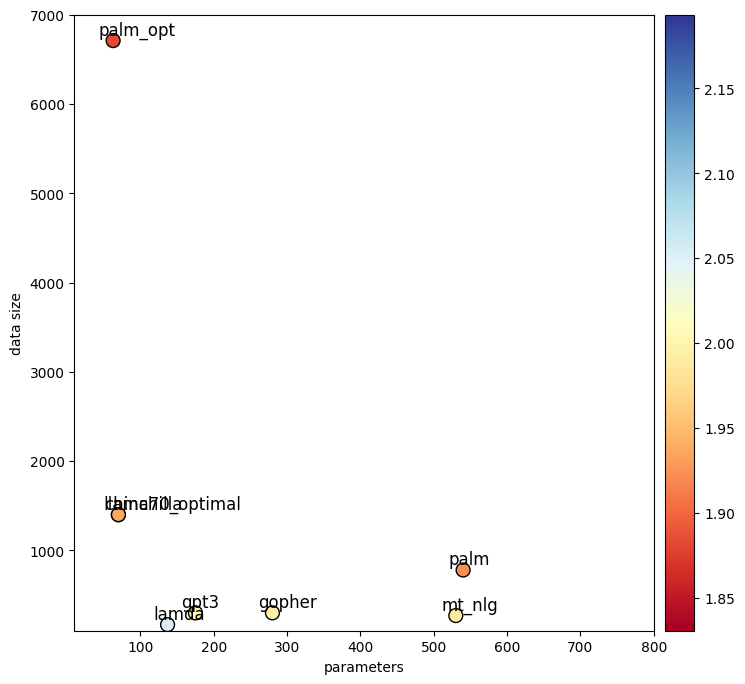

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(8, 8))
im = plt.scatter(df2.n, df2.d, c=df2.scaling_loss, lw=1, edgecolors='k', s=100, cmap='RdYlBu', vmin=lgrid.min(), vmax=lgrid.max());


for name in df2.index:
    plt.text(df2.loc[name, 'n'] - 20, df2.loc[name, 'd'] + 60, name, fontdict=dict(fontsize=12))

plt.axis([NMIN, NMAX, DMIN, DMAX]);
plt.xlabel('parameters')
plt.ylabel('data size')

ax = plt.gca()
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax)

##### loss vs compute

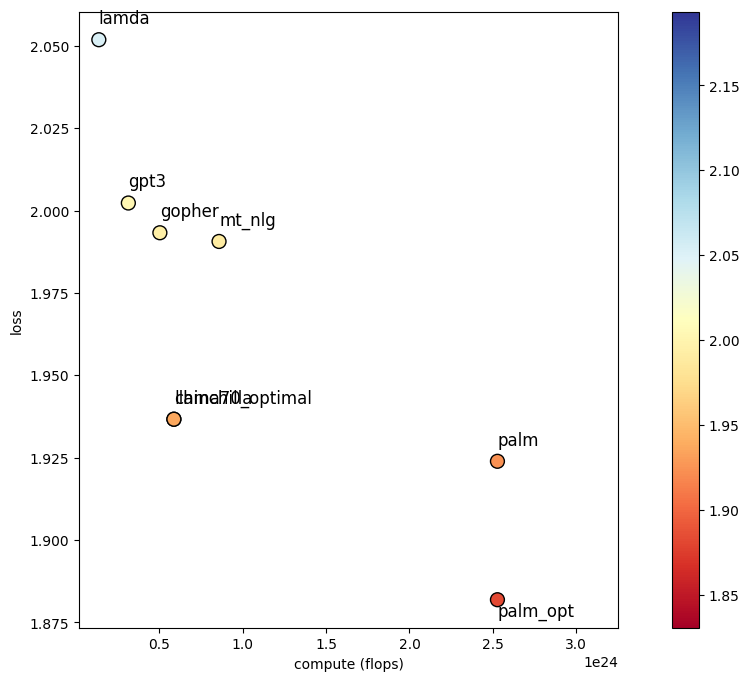

In [17]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(8, 8))

im = plt.scatter(df2.flops, df2.scaling_loss, lw=1, c=df2.scaling_loss, edgecolors='k', s=100, cmap='RdYlBu', vmin=lgrid.min(), vmax=lgrid.max());

for name in df2.index:
    yoff = 0.005
    if name == 'palm_opt':
        yoff = -0.005
    plt.text(df2.loc[name, 'flops'] - 60, df2.loc[name, 'scaling_loss'] + yoff, name, fontdict=dict(fontsize=12))

plt.xlabel('compute (flops)')
plt.ylabel('loss')

plt.xlim(plt.xlim()[0], 3.25e24)

ax = plt.gca()
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="10%")
cb1 = fig.colorbar(im, cax=cax)

### to infinity

In [18]:
# set n or d to infinity, by setting the corresponding term to 0

def l_infs(n, d, inf_n=False, inf_d=False):
    # n, d in billions
    n = n * 1e9
    d = d * 1e9
    return 1.69 + (1 - inf_n) * 406.4/(n ** 0.34) + (1 - inf_d) * 410.7/(d ** 0.28)

In [19]:
inf_losses_n = {}
inf_losses_d = {}
for name in df.index:
    if name in {'lamda', 'gpt3'}:
        continue

    inf_losses_n[name] = {
        'data': model_hparams[name][1],
        'scaling_loss': l_infs(*model_hparams[name])
    }
    inf_losses_n[f'{name} (∞ params)'] = {
        'data': model_hparams[name][1],
        'scaling_loss': l_infs(*model_hparams[name], inf_n=True)
    }


    inf_losses_d[f'{name} (∞ data)'] = {
        'params': model_hparams[name][0],
        'scaling_loss': l_infs(*model_hparams[name], inf_d=True)
    }

df_inf_losses_n = pd.DataFrame(inf_losses_n).T
df_inf_losses_d = pd.DataFrame(inf_losses_d).T

Text(0.5, 0, 'data (B)')

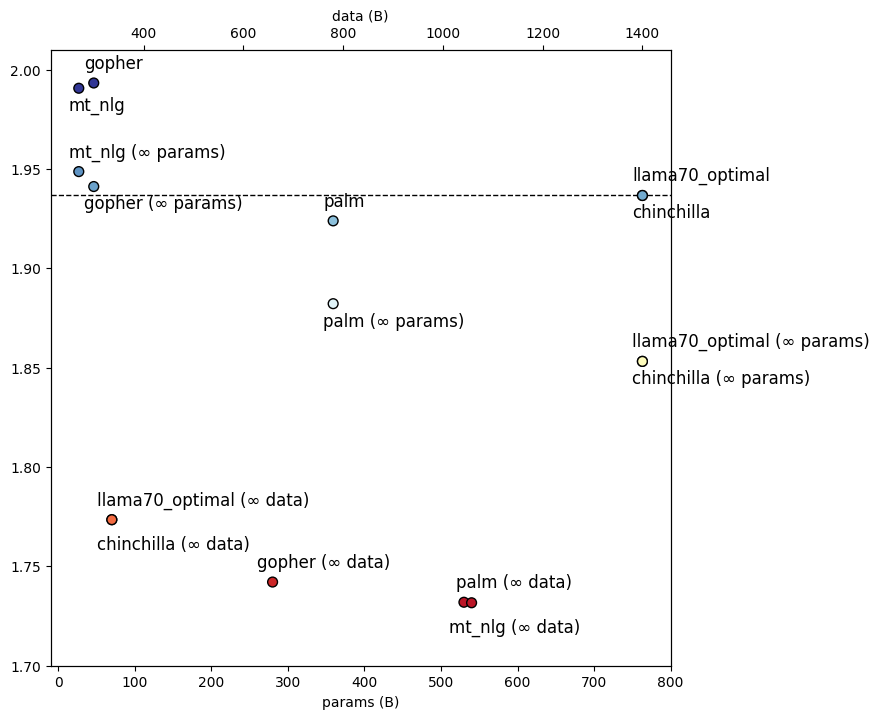

In [20]:
plt.figure(figsize=(8, 8))

plt.scatter(df_inf_losses_d.params, df_inf_losses_d.scaling_loss,
            c=df_inf_losses_d.scaling_loss, lw=1, edgecolors='k', s=50, cmap='RdYlBu', vmin=1.72, vmax=1.99)
plt.xlabel('params (B)')

tyoff = 0.0075
txoff = -20
for i, name in enumerate(df_inf_losses_d.sort_values('scaling_loss').index):
    plt.text(df_inf_losses_d.loc[name, 'params'] + txoff,
             df_inf_losses_d.loc[name, 'scaling_loss'] + tyoff * (-2 if i % 2 else 1),
             name, fontdict=dict(fontsize=12))

plt.axhline(df_inf_losses_n.loc['chinchilla', 'scaling_loss'], c='k', ls='--', label='chinchilla', lw=1)
plt.axis((NMIN - 20, NMAX, 1.72 - 0.02, 1.99 + 0.02))

ax2 = plt.gca().twiny()

ax2.scatter(df_inf_losses_n.data, df_inf_losses_n.scaling_loss,
            c=df_inf_losses_n.scaling_loss, lw=1, edgecolors='k', s=50, cmap='RdYlBu', vmin=1.72, vmax=1.99)

for i, name in enumerate(df_inf_losses_n.sort_values('scaling_loss').index):
    ax2.text(df_inf_losses_n.loc[name, 'data'] + txoff,
             df_inf_losses_n.loc[name, 'scaling_loss'] + tyoff * (1 if i % 2 else -1.5),
             name, fontdict=dict(fontsize=12))

ax2.set_xlabel('data (B)')

#### appendix: 1/n, 1/d coordinates

dunno why i did this...

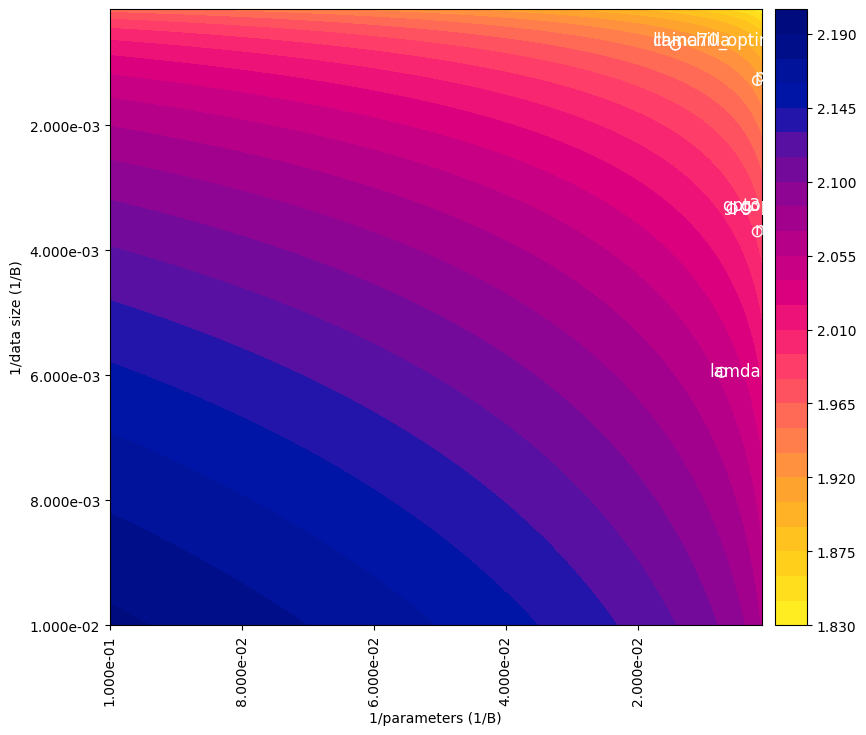

In [21]:
import numpy as np
import matplotlib.ticker

ns, ds = np.meshgrid(np.linspace(1/NMAX, 1/NMIN, NMAX-NMIN), np.linspace(1/DMAX, 1/DMIN, DMAX-DMIN))

lgrid =  l(1/ns, 1/ds)

fig = plt.figure(figsize=(9, 8))

shared_kwargs = dict(cmap='cet_bmy_r', vmin=lgrid.min(), vmax=lgrid.max())

im = plt.contourf(ns, ds, lgrid, levels=30, **shared_kwargs, )

ax = plt.gca()
plt.xlabel('1/parameters (1/B)')
plt.ylabel('1/data size (1/B)')

ax.invert_xaxis()
ax.invert_yaxis()
x_off = NMIN
y_off = DMIN

ax.scatter(1/df.n, 1/df.d, c=df.scaling_loss, lw=1, edgecolors='w', s=50, **shared_kwargs)

for name in df.index:
    plt.text(
        1/(df.loc[name, 'n'] * 0.8), 1/(df.loc[name, 'd'] * 0.99), name,
        fontdict=dict(fontsize=12, color='w')
    )

ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f"{x:.3e}" ))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, pos: f"{y:.3e}" ))

ax.tick_params(axis='x', rotation=90)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax)